# Введение в задачи обработки изображений и архитектуры сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
  * https://huggingface.co/docs/transformers/v4.39.0/en/main_classes/pipelines#transformers.pipeline
  * https://medium.com/@diego.machado/fine-tuning-vit-for-image-classification-with-hugging-face-48c4be31e367
  * https://huggingface.co/docs/transformers/v4.39.0/en/main_classes/optimizer_schedules#transformers.SchedulerType
  * https://huggingface.co/docs/datasets/main/en/package_reference/loading_methods#datasets.load_dataset
  * https://huggingface.co/docs/transformers/training
  * https://huggingface.co/docs/datasets/use_dataset

In [2]:
!pip install datasets evaluate accelerate

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

## Задачи для совместного разбора

1\. Создайте `pipeline` для модели `microsoft/resnet-50`. Загрузите датасет `fashion_mnist`. Получите прогноз для одного из изображений датасета.

In [3]:
from transformers import pipeline
from datasets import load_dataset
from transformers.image_utils import load_image

2024-03-23 20:03:43.805573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gblssroman/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gblssroman/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
model_id = "microsoft/resnet-50"

classifier = pipeline(task="image-classification", model=model_id)
classifier

/home/gblssroman/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
dataset = load_dataset("fashion_mnist")
dataset

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/gblssroman/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
image = dataset["train"][0]["image"]
# type(image)
image

In [8]:
classifier(image)

[{'score': 0.14105382561683655, 'label': 'cowboy boot'},
 {'score': 0.07241983711719513, 'label': 'Loafer'},
 {'score': 0.061765458434820175,
  'label': 'affenpinscher, monkey pinscher, monkey dog'},
 {'score': 0.06028478220105171, 'label': 'bulletproof vest'},
 {'score': 0.055056896060705185, 'label': 'triceratops'}]

In [9]:
model = classifier.model
processor = classifier.image_processor

In [10]:
image_loaded = load_image(image)
model_input = processor(image_loaded, return_tensors="pt")
out = model(**model_input)

In [11]:
logits = out.logits
logits.shape

torch.Size([1, 1000])

In [12]:
logits.argmax()

tensor(514)

In [13]:
model.config.id2label[514]

'cowboy boot'

2\. Обсудите процедуру дообучения модели классификации изображений и возможность использования новой модели в `pipeline`.

In [15]:
model

In [16]:
type(model)

transformers.models.resnet.modeling_resnet.ResNetForImageClassification

In [17]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [18]:
class_names = dataset["train"].features["label"].names
id2label = {idx: name for idx, name in enumerate(class_names)}
id2label

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [19]:
processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=10,
    ignore_mismatched_sizes=True,
    id2label=id2label
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.config.id2label

{0: 'T - shirt / top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [21]:
model.classifier[1].weight

Parameter containing:
tensor([[-1.2685e-02,  2.2001e-02, -7.2414e-03,  ...,  1.8910e-02,
         -1.9485e-02, -1.8821e-03],
        [-1.9418e-03, -9.8498e-03,  1.1790e-02,  ...,  7.7181e-03,
          3.3555e-04,  8.7648e-03],
        [ 1.9969e-03,  1.5510e-02, -7.0466e-03,  ..., -6.1883e-03,
          1.8297e-02, -1.8661e-02],
        ...,
        [ 3.8531e-03,  6.1695e-03, -1.3066e-02,  ..., -6.6669e-03,
          1.7506e-02,  6.6360e-03],
        [-2.6279e-03,  1.6019e-02, -1.5987e-02,  ...,  2.1748e-02,
         -5.6562e-03, -5.6931e-03],
        [ 1.8154e-02, -2.1681e-02, -2.0529e-02,  ..., -1.9700e-02,
         -7.1123e-05,  1.3633e-02]], requires_grad=True)

In [23]:
conv = model.resnet.embedder.embedder.convolution
conv.weight

In [24]:
for name, parameter in model.named_parameters():
  print(name)
  if name.startswith("classifier"):
    parameter.requires_grad = True
  else:
    parameter.requires_grad = False

resnet.embedder.embedder.convolution.weight
resnet.embedder.embedder.normalization.weight
resnet.embedder.embedder.normalization.bias
resnet.encoder.stages.0.layers.0.shortcut.convolution.weight
resnet.encoder.stages.0.layers.0.shortcut.normalization.weight
resnet.encoder.stages.0.layers.0.shortcut.normalization.bias
resnet.encoder.stages.0.layers.0.layer.0.convolution.weight
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias
resnet.encoder.stages.0.layers.0.layer.1.convolution.weight
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight
resnet.encoder.stages.0.layers.0.layer.1.normalization.bias
resnet.encoder.stages.0.layers.0.layer.2.convolution.weight
resnet.encoder.stages.0.layers.0.layer.2.normalization.weight
resnet.encoder.stages.0.layers.0.layer.2.normalization.bias
resnet.encoder.stages.0.layers.1.layer.0.convolution.weight
resnet.encoder.stages.0.layers.1.layer.0.normalization.weight
resnet.encode

In [27]:
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(1000))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(100))

In [28]:
model.config.num_labels

10

In [30]:
new_classifier = pipeline(task="image-classification", model="...")

3\. Рассмотрите пример работы с моделью распознавания объектов

In [2]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
from io import BytesIO

In [47]:
url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [50]:
# you can specify the revision tag if you don't want the timm dependency
processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

/home/gblssroman/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [51]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [52]:
# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs,
    target_sizes=target_sizes,
    threshold=0.5
)[0]

In [53]:
results

{'scores': tensor([0.9994], grad_fn=<IndexBackward0>),
 'labels': tensor([17]),
 'boxes': tensor([[   3.5893,  346.8431, 2771.1943, 3044.1445]],
        grad_fn=<IndexBackward0>)}

In [54]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected cat with confidence 0.999 at location [3.59, 346.84, 2771.19, 3044.14]


---

## Задачи для самостоятельного решения

1\. Используя `transformers.Trainer`, дообучите модель `microsoft/resnet-50` на датасете `fashion-mnist`. При создании модели адаптируйте размерность выходного слоя и маппинг идентификаторов классов в соответствии с решаемой задачей.

Исследуйте, как влияет количество замороженных весов на процесс обучения. Исследуйте, как влияет планировщик скорости обучения на процесс настройки.

Для ускорения процесса обучения вы можете использовать GPU или уменьшить размер обучающей выборки.

**Сделаем на PyTorch**

In [228]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from transformers import AutoModel

def get_mnist_data(batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=False, train=True, root='.').train_data.float()

    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])

    trainplusval = torchvision.datasets.FashionMNIST('.', train=True, download=True, transform=transform)
    test = torchvision.datasets.FashionMNIST('.', train=False, download=True, transform=transform)

    train_idx, val_idx = train_test_split(np.arange(len(trainplusval)),
        random_state=42, test_size=0.3, shuffle=True
    )

    train = Subset(trainplusval, train_idx)
    val = Subset(trainplusval, val_idx)

    train_loader = DataLoader(train, batch_size=batch_size, num_workers=8, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, num_workers=8, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, num_workers=8, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_mnist_data(batch_size=16)

In [229]:
len(torchvision.datasets.FashionMNIST('', train=True, download=True))

60000

In [230]:
len(train_loader)

2625

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


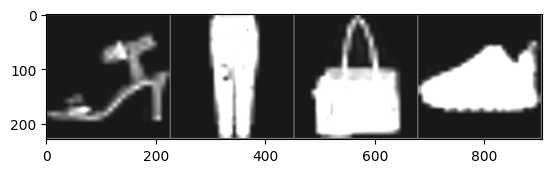

Sandal Trouser Bag Sneaker


In [137]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot')
print(*[classes[labels[i]] for i in range(4)])

In [226]:
class ResNet50_clf(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super(ResNet50_clf, self).__init__()

        self.model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # orig: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        out_orig = self.model.fc.in_features
        self.model.fc = nn.Linear(out_orig, out_classes)
        torch.nn.init.xavier_uniform_(self.model.fc.weight)

    def forward(self, x):
        return self.model(x)

model = ResNet50_clf()      

In [161]:
model

ResNet50_clf(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

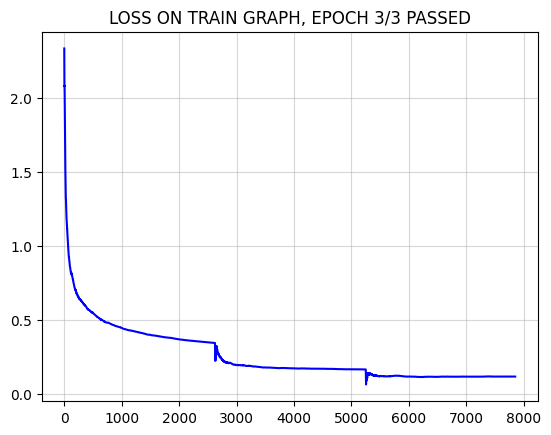

[TRAIN] Loss: 0.3419 F1-macro (step): 0.8667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2625/2625 [08:06<00:00,  5.40it/s]

DECREASED LR TO: 3.0000000000000004e-07



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [27:09<00:00, 543.17s/it]


In [232]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import clear_output

NUM_EPOCHS = 3
LR = 3e-4

model = ResNet50_clf()   
model.to('cuda')
optimizer = optim.AdamW(params=model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, verbose=True)
loss = nn.CrossEntropyLoss()

macro_f1_train, loss_train = [], []
macro_f1_val, loss_val = [], []
norm_loss = []

for epochs in tqdm(range(NUM_EPOCHS)):
    total_loss = 0
    total_val_loss = 0
    
    model.train()
    progress_bar = tqdm(enumerate(train_loader), desc='Starting train...', total=len(train_loader), position=0, leave=True)
    
    for step, (images, labels) in progress_bar:
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        preds = model(images)
        curr_loss = loss(preds, labels)
        curr_loss.backward()
        optimizer.step()

        loss_train.append(curr_loss.item())
        macro_f1_train.append(f1_score(labels.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1), average='macro'))
        total_loss += curr_loss.item()
        norm_loss.append(total_loss/(step+1))

        progress_bar.set_description(f"[TRAIN] Loss: {round(norm_loss[step], 4)} F1-macro (step): {round(macro_f1_train[step], 4)}")

        if step % 50 == 0:
            clear_output()
            plt.title(f"LOSS ON TRAIN GRAPH, EPOCH {epochs+1}/{NUM_EPOCHS} PASSED")
            plt.plot(norm_loss, color='blue')
            plt.grid(alpha=0.5)
            plt.show()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    scheduler.step()
    print(f'''DECREASED LR TO: {optimizer.param_groups[0]["lr"]}''')

    model.eval()
    progress_bar = tqdm(enumerate(val_loader), desc='Starting val...', total=len(val_loader), position=0, leave=True)
    for step, (images, labels) in progress_bar:
        images, labels = images.to('cuda'), labels.to('cuda')

        preds = model(images)
        curr_loss = loss(preds, labels)

        loss_val.append(curr_loss.item())
        macro_f1_val.append(f1_score(labels.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1), average='macro'))
        total_val_loss += curr_loss.item()

        progress_bar.set_description(f"[VAL] Loss: {round(total_val_loss/(step+1), 4)} F1-macro (step): {round(macro_f1_val[step], 4)}")


2\. Создайте новый `pipeline` на основе любой из обученных в предыдущем задании моделей. Продемонстируйте пример работы на нескольких изображениях.

**В HF: class transformers.ImageClassificationPipeline для модели с измененной головой**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


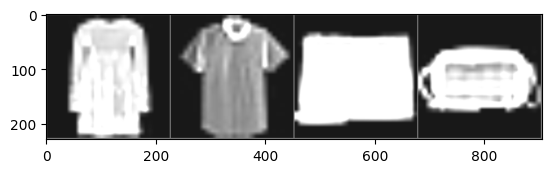

In [233]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot')
print(*[classes[labels[i]] for i in range(4)])

In [ ]:
avg_f1_test = 0

with torch.no_grad():
    for step, (images, labels) in progress_bar:
        images, labels = images.to('cuda'), labels.to('cuda')

        preds = model(images)
        curr_loss = loss(preds, labels)

        loss_val.append(curr_loss.item())
        macro_f1_val.append(f1_score(labels.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1), average='macro'))
        total_val_loss += curr_loss.item()

        progress_bar.set_description(f"[VAL] Loss: {round(total_val_loss/(step+1), 4)} F1-macro (step): {round(macro_f1_val[step], 4)}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


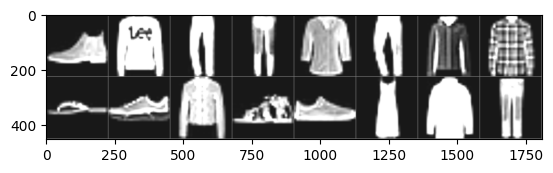

Реальные лейблы: Ankleboot Pullover Trouser Trouser Shirt Trouser Coat Shirt Sandal Sneaker Coat Sandal Sneaker Dress Coat Trouser


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


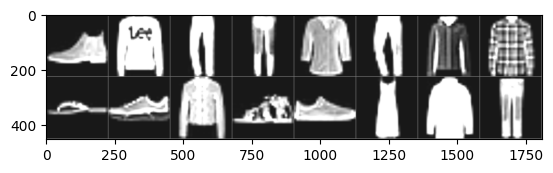

Предсказанные лейблы: Ankleboot Pullover Trouser Trouser T-shirt/top Trouser Coat Shirt Sandal Sneaker Coat Sandal Sandal Dress Coat Trouser


In [274]:
testiter = iter(test_loader)
images, real_labels = next(testiter)

imshow(torchvision.utils.make_grid(images[:16]))
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot')
print("Реальные лейблы:", *[classes[labels[i]] for i in range(16)])

batch_count = 0
with torch.no_grad():
    for step, (images, labels) in enumerate(test_loader):
        while batch_count != 1:
            images, labels = images.to('cuda'), labels.to('cuda')
            imshow(torchvision.utils.make_grid(images.cpu()[:16]))
    
            preds = np.argmax(model(images).cpu().detach().numpy(), axis=1)
            batch_count += 1
print("Предсказанные лейблы:", *[classes[preds[i]] for i in range(16)])

**Видим, что для семпла в 16 изображений модель ошиблась в 2 (не отличила рубашку под индексом 4 от топа и ошибочно классифицировало кроссовок под индексом -4 как сандаль) - ошибки в целом адекватны, при необходимости можно сделать побольше эпох и начать с более высокого LR.**

3\. Найдите в сети фотографию с изображением живых существ (котики, собачки, люди и т.д.). Найдите модель для решения задачи выделения объектов на изображении. Используя классы `AutoImageProcessor` и `AutoModelForObjectDetection`, создайте соответствующие объекты для решения задачи и сделайте прогноз для вашей фотографии.

Визуализируйте полученные результаты, изобразив на картинке прямоугольники (bounding box) с выделенными объектами. Для визуализиции можете адаптировать [этот пример](https://stackoverflow.com/a/37437395).

In [3]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initiali

In [48]:
requests.get('https://storage-api.petstory.ru/resize/1000x1000x80/10/e4/da/10e4dac1fdc94a97811fe3d50a25b7da.jpeg')

<Response [200]>

In [50]:
import requests

dogs_img = Image.open('misc/doggos.jpg')
#requests.get('https://storage-api.petstory.ru/resize/1000x1000x80/10/e4/da/10e4dac1fdc94a97811fe3d50a25b7da.jpeg'
dogs_img.size

(1000, 667)

In [6]:
inputs = processor(images=dogs_img, return_tensors="pt")
outputs = model(**inputs)

In [11]:
target_sizes = torch.tensor([dogs_img.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
results

{'scores': tensor([0.9868, 0.9577, 0.9824], grad_fn=<IndexBackward0>),
 'labels': tensor([18, 18, 18]),
 'boxes': tensor([[699.5776, 229.8210, 948.5469, 518.8344],
         [105.8489, 199.2578, 723.9484, 545.4198],
         [558.1943, 382.0636, 762.7922, 552.1362]], grad_fn=<IndexBackward0>)}

In [18]:
model.config.id2label[18]

'dog'

(https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/DETR_minimal_example.ipynb)

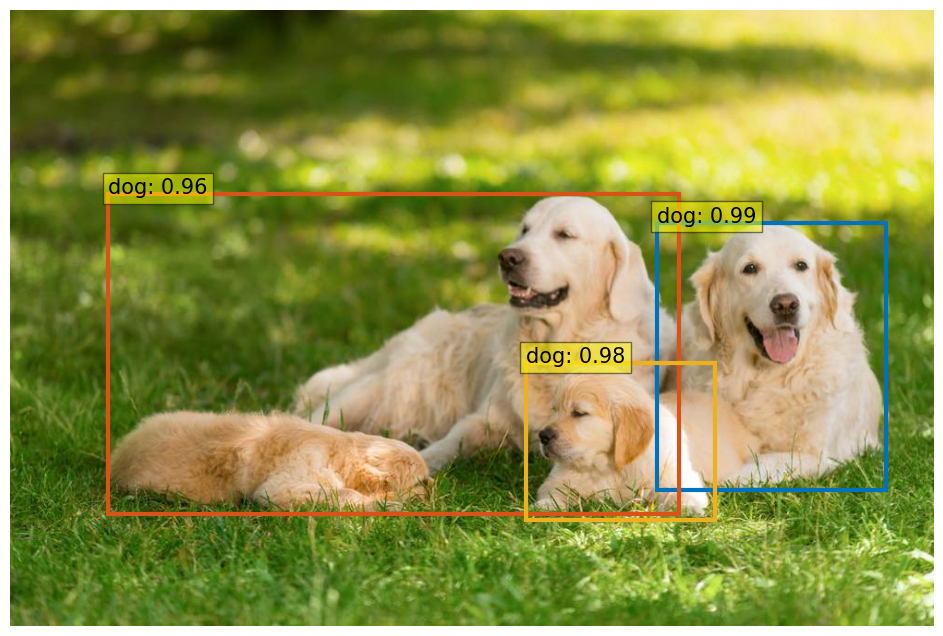

In [40]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

width, height = dogs_img.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]

plot_results(dogs_img, results['scores'], results['labels'], results['boxes'])